Load the FEN data, define the test_train dataset, and pass to a neural net

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from sklearn.model_selection import train_test_split
import os 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

D:\Anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
Dataset_10 = pd.read_csv('Data\\Standard 1000-1199\\hot1.csv')
Dataset_12 = pd.read_csv('Data\\Standard 1200-1399\\hot1.csv')
Dataset_14 = pd.read_csv('Data\\Standard 1400-1599\\hot1.csv')
Dataset_16 = pd.read_csv('Data\\Standard 1600-1799\\hot1.csv')
Dataset_18 = pd.read_csv('Data\\Standard 1800-1999\\hot1.csv')
Dataset_20 = pd.read_csv('Data\\Standard 2000-2199\\hot1.csv')
Dataset_22 = pd.read_csv('Data\\Standard 2200-2399\\hot1.csv')
Dataset_24 = pd.read_csv('Data\\Standard 2400-2599\\hot1.csv')


Dataset_list = [Dataset_10,
               Dataset_12,
               Dataset_14,
               Dataset_16,
               Dataset_18,
               Dataset_20,
               Dataset_22,
               Dataset_24]

In [4]:
def Feature_Label_Extraction(df_in,num_of_examples = 3746):
    df_out = df_in[0:num_of_examples]
    df_out_feature = df_out.iloc[:,:832]
    
    white_elos = df_out["White ELO"].astype(int)
    black_elos = df_out["Black ELO"].astype(int)
    avg_elos = np.mean([np.array(white_elos),np.array(black_elos)],axis=0)
    
    df_out_label = pd.DataFrame(columns = ["Average ELO"])
    df_out_label["Average ELO"] = avg_elos
    
    #df_out_label = white_elos
    return df_out_feature , df_out_label
    
def Prepare_Datasets(dataset_list):
    out_df_feature = pd.DataFrame()
    out_df_label = pd.DataFrame()
    for dataframe in dataset_list:
        feature , label = Feature_Label_Extraction(dataframe)
        out_df_feature = out_df_feature.append(feature,ignore_index=True)
        #out_df_label = out_df_label.append(label,ignore_index = True)
        out_df_label = pd.concat([out_df_label,label])
        print(np.size(label))
    return out_df_feature , out_df_label


def Hot_1_encoder(df_in):
    New_array = np.zeros([df_in.shape[0],df_in.shape[1]*13])
    for i in range(df_in.shape[0]):
        for j,val in enumerate(df_in.iloc[i][:]):
            New_array[i,13*j+int(val)] = 1
            
    return New_array

In [5]:
trainx, trainy = Prepare_Datasets(Dataset_list)

3746
3746
3746
3746
3746
3746
3746
3746


In [6]:
print(trainy.min(),trainy.max())

Average ELO    1002.0
dtype: float64 Average ELO    2599.0
dtype: float64


In [7]:
#Normalize y
trainy = (trainy- trainy.min())/(trainy.max()-trainy.min())

In [8]:
X_train, X_test, y_train, y_test = train_test_split(trainx, trainy, test_size=0.1)

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [11]:
#with tf.device('/DML:0'): 
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(832,)),
    keras.layers.Dense(832, activation = "relu"),
    keras.layers.Dense(832, activation = "relu"),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(8, activation = "relu"),
    keras.layers.Dense(4, activation = "relu"),
    keras.layers.Dense(1, activation = "linear")
])

#custom_optimizer=tf.keras.optimizers.SGD(learning_rate=0.02)


model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(1e-3), metrics=['mean_squared_error'],)

history = model.fit(X_train,y_train, epochs = 5, validation_split=0.05)

Epoch 1/5
801/801 [==============================] - 14s 16ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 2/5
801/801 [==============================] - 13s 16ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 3/5
801/801 [==============================] - 11s 14ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 4/5
801/801 [==============================] - 12s 15ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 5/5
801/801 [==============================] - 11s 14ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0450 - val_mean_squared_error: 0.0450


In [12]:
history_df = pd.DataFrame(history.history)


mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

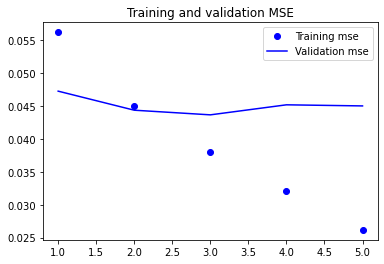

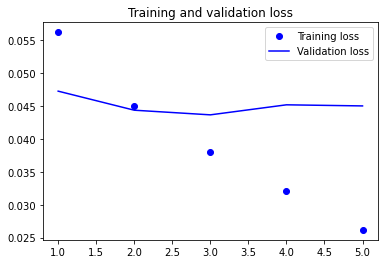

In [13]:
epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation MSE')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

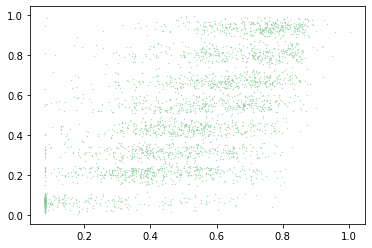

In [14]:
plt.scatter(model.predict_on_batch(X_test),y_test,c='#88c999',s=0.1)

In [15]:
#plt.scatter(model.predict_on_batch(X_test)[0],y_test[0])
#y_test.iloc[0,1]
#np.size(model.predict_on_batch(X_test)[:][0])
#print(model.predict_on_batch(X_test)[3][0])


In [16]:
model.save('Move40_arch1')

INFO:tensorflow:Assets written to: Move40_arch1\assets


In [17]:
trainy.max()

Average ELO    1.0
dtype: float64